In [15]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms

import os
import argparse
import pickle
import numpy as np
import pdb
import time
from PIL import Image


import sys
sys.path.insert(1, '../')
from models import *
from utils import progress_bar
from cifar_new import CIFAR_New

In [10]:
print('==> Preparing data..')
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

all_trainset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=False, transform=None)

testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=False, transform=None)


testset_new = CIFAR_New(root='../data', transform=None)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


In [2]:
with open("../out/cifar10_summary.pkl", "rb") as f:
    out = pickle.load(f)

In [3]:
out.keys()

dict_keys(['mask', 'acc_train', 'acc_test', 'acc_test_new', 'mem_score', 'idx', 'infl_score_test', 'infl_score_testnew'])

First, look at the overall training and test accuracies

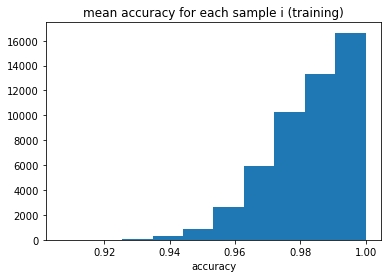

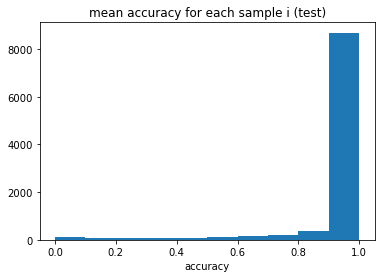

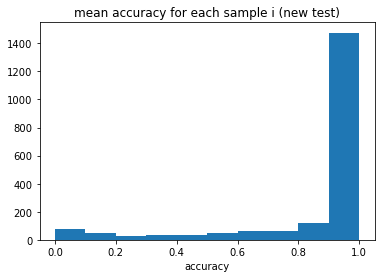

In [4]:
plt.hist(out["acc_train"].mean(axis = 0))
plt.xlabel("accuracy")
plt.title("mean accuracy for each sample i (training)")
plt.show()

plt.hist(out["acc_test"].mean(axis = 0))
plt.xlabel("accuracy")
plt.title("mean accuracy for each sample i (test)")
plt.show()

plt.hist(out["acc_test_new"].mean(axis = 0))
plt.xlabel("accuracy")
plt.title("mean accuracy for each sample i (new test)")
plt.show()

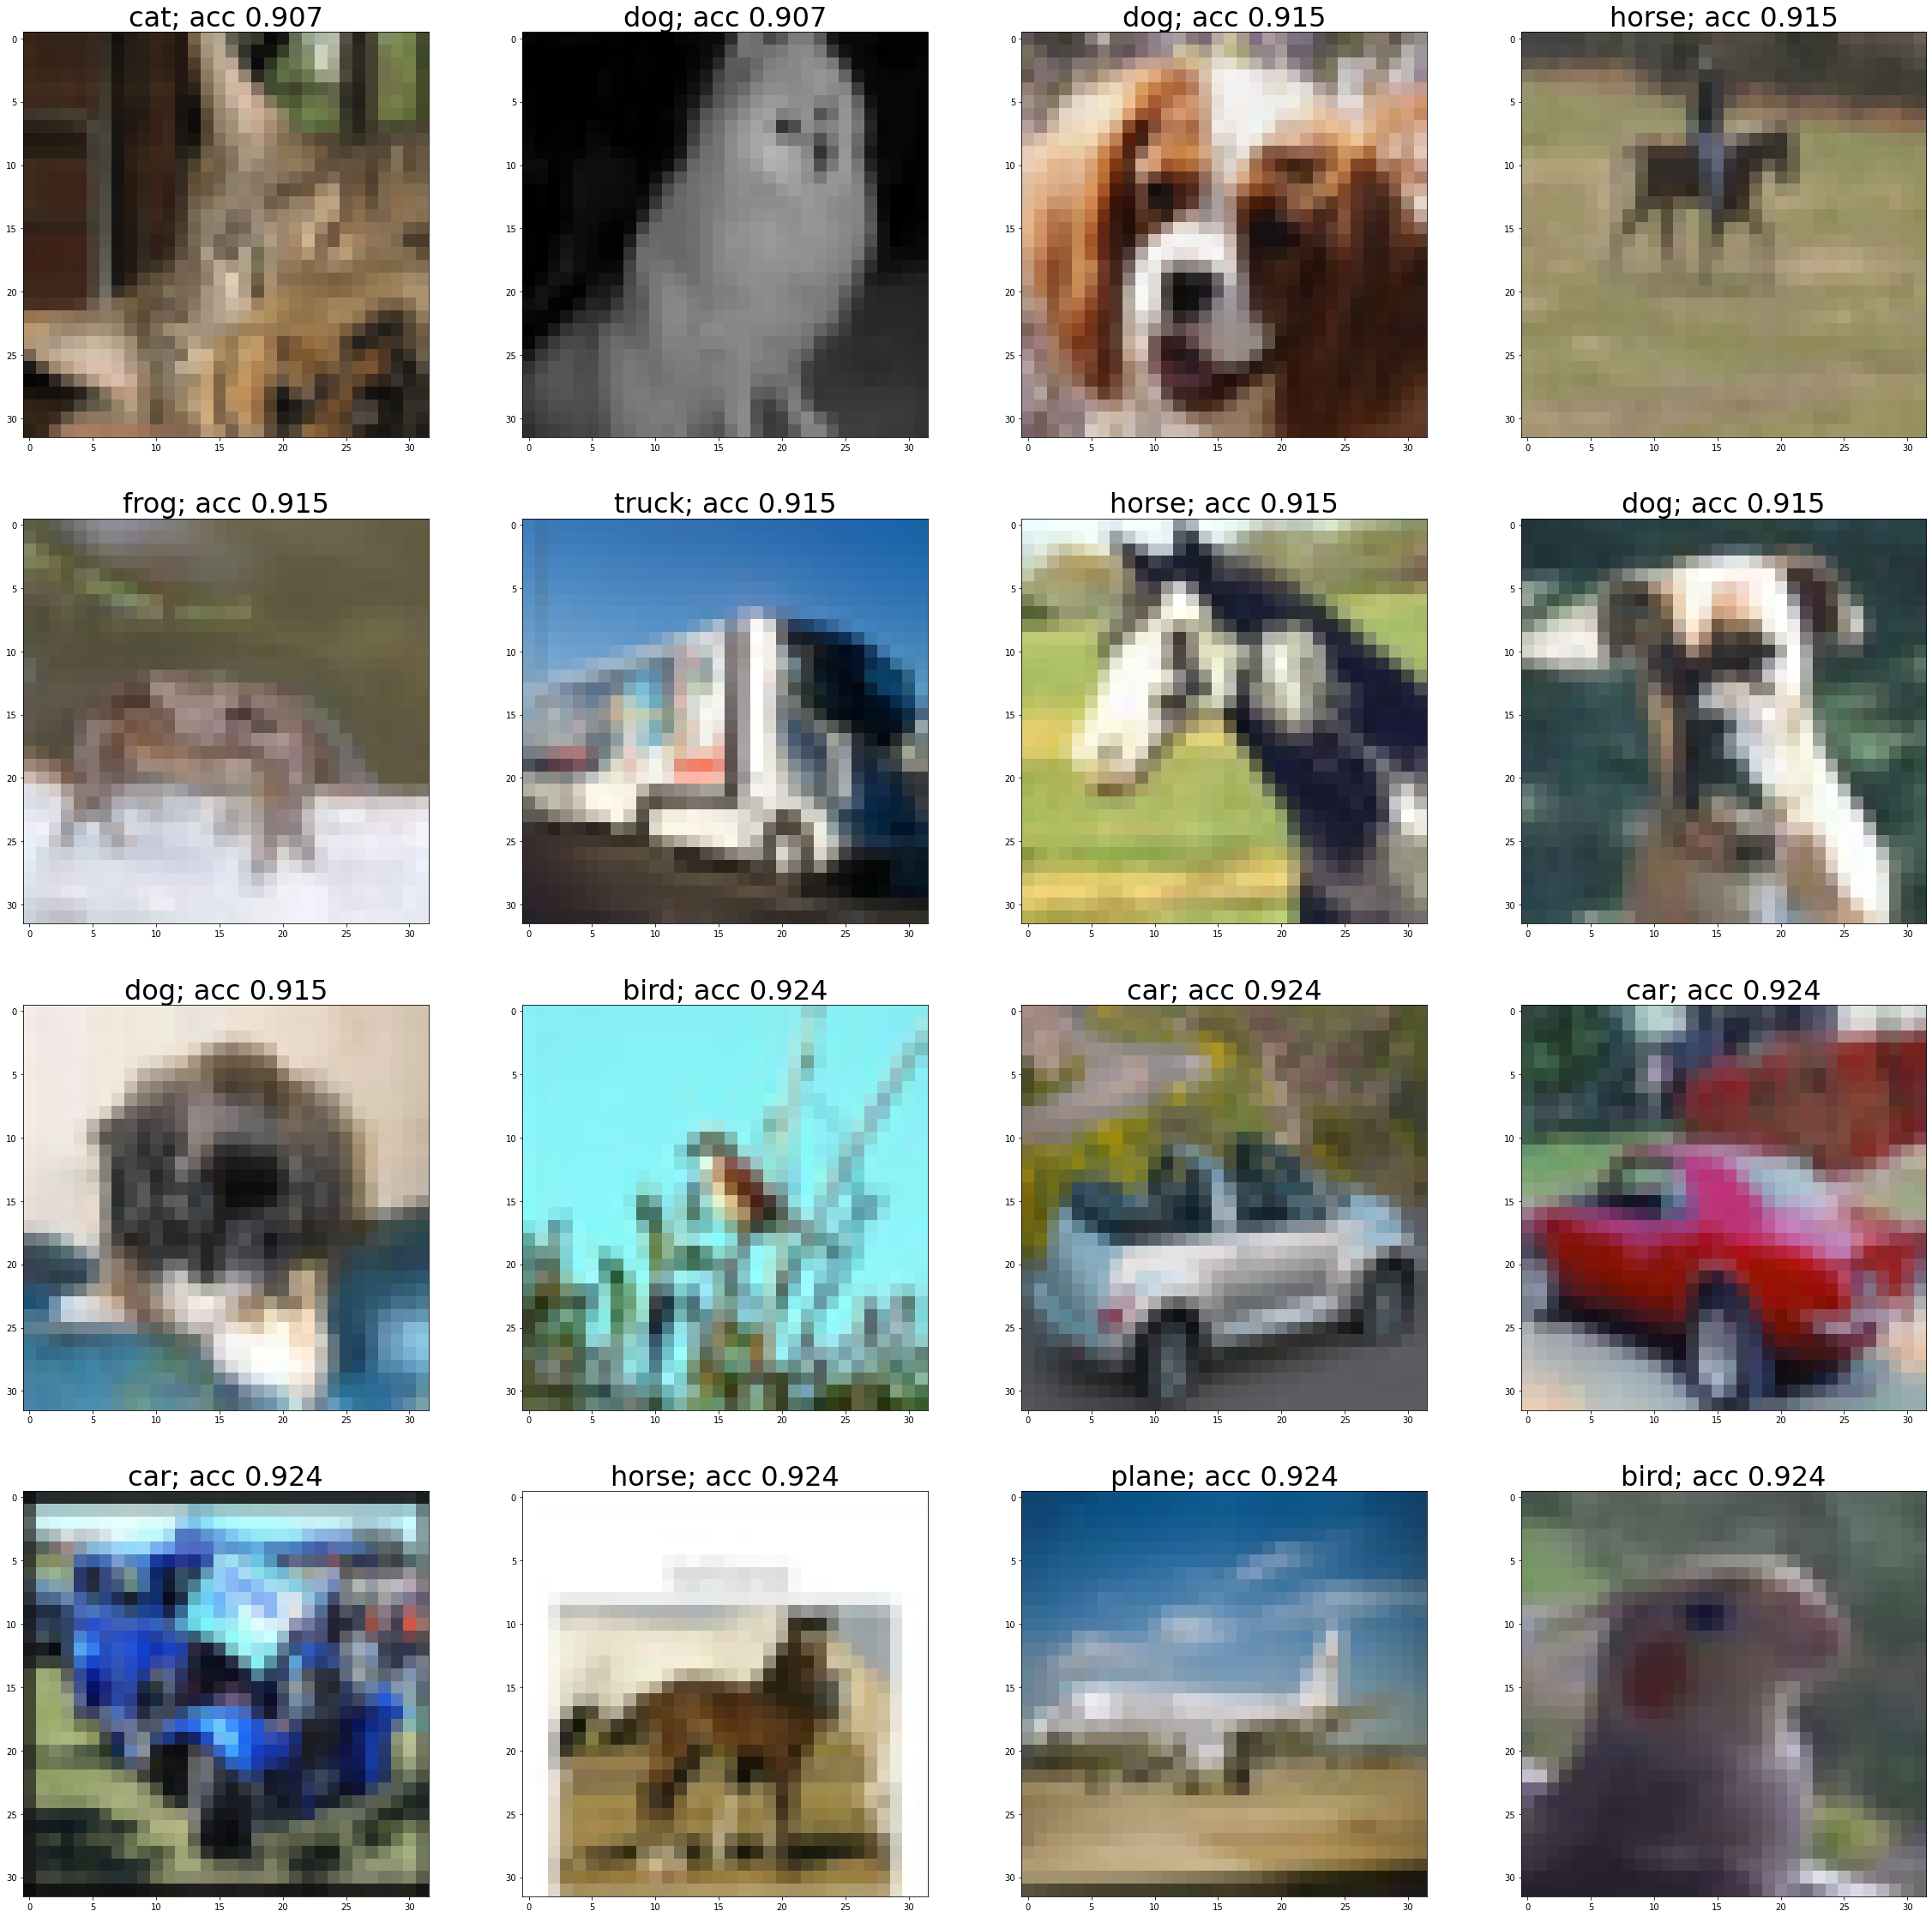

In [55]:
num = 16
columns=4
rows = int(num / columns)
width = 40
height = 40

acc = out["acc_train"].mean(axis = 0)
data = all_trainset
plt.figure(figsize=(width, height))
for i, ix in enumerate(np.argsort(acc)[:num]):        
    image, label = data[ix]
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}; acc {acc[ix].round(3)}", fontsize = 32)
    

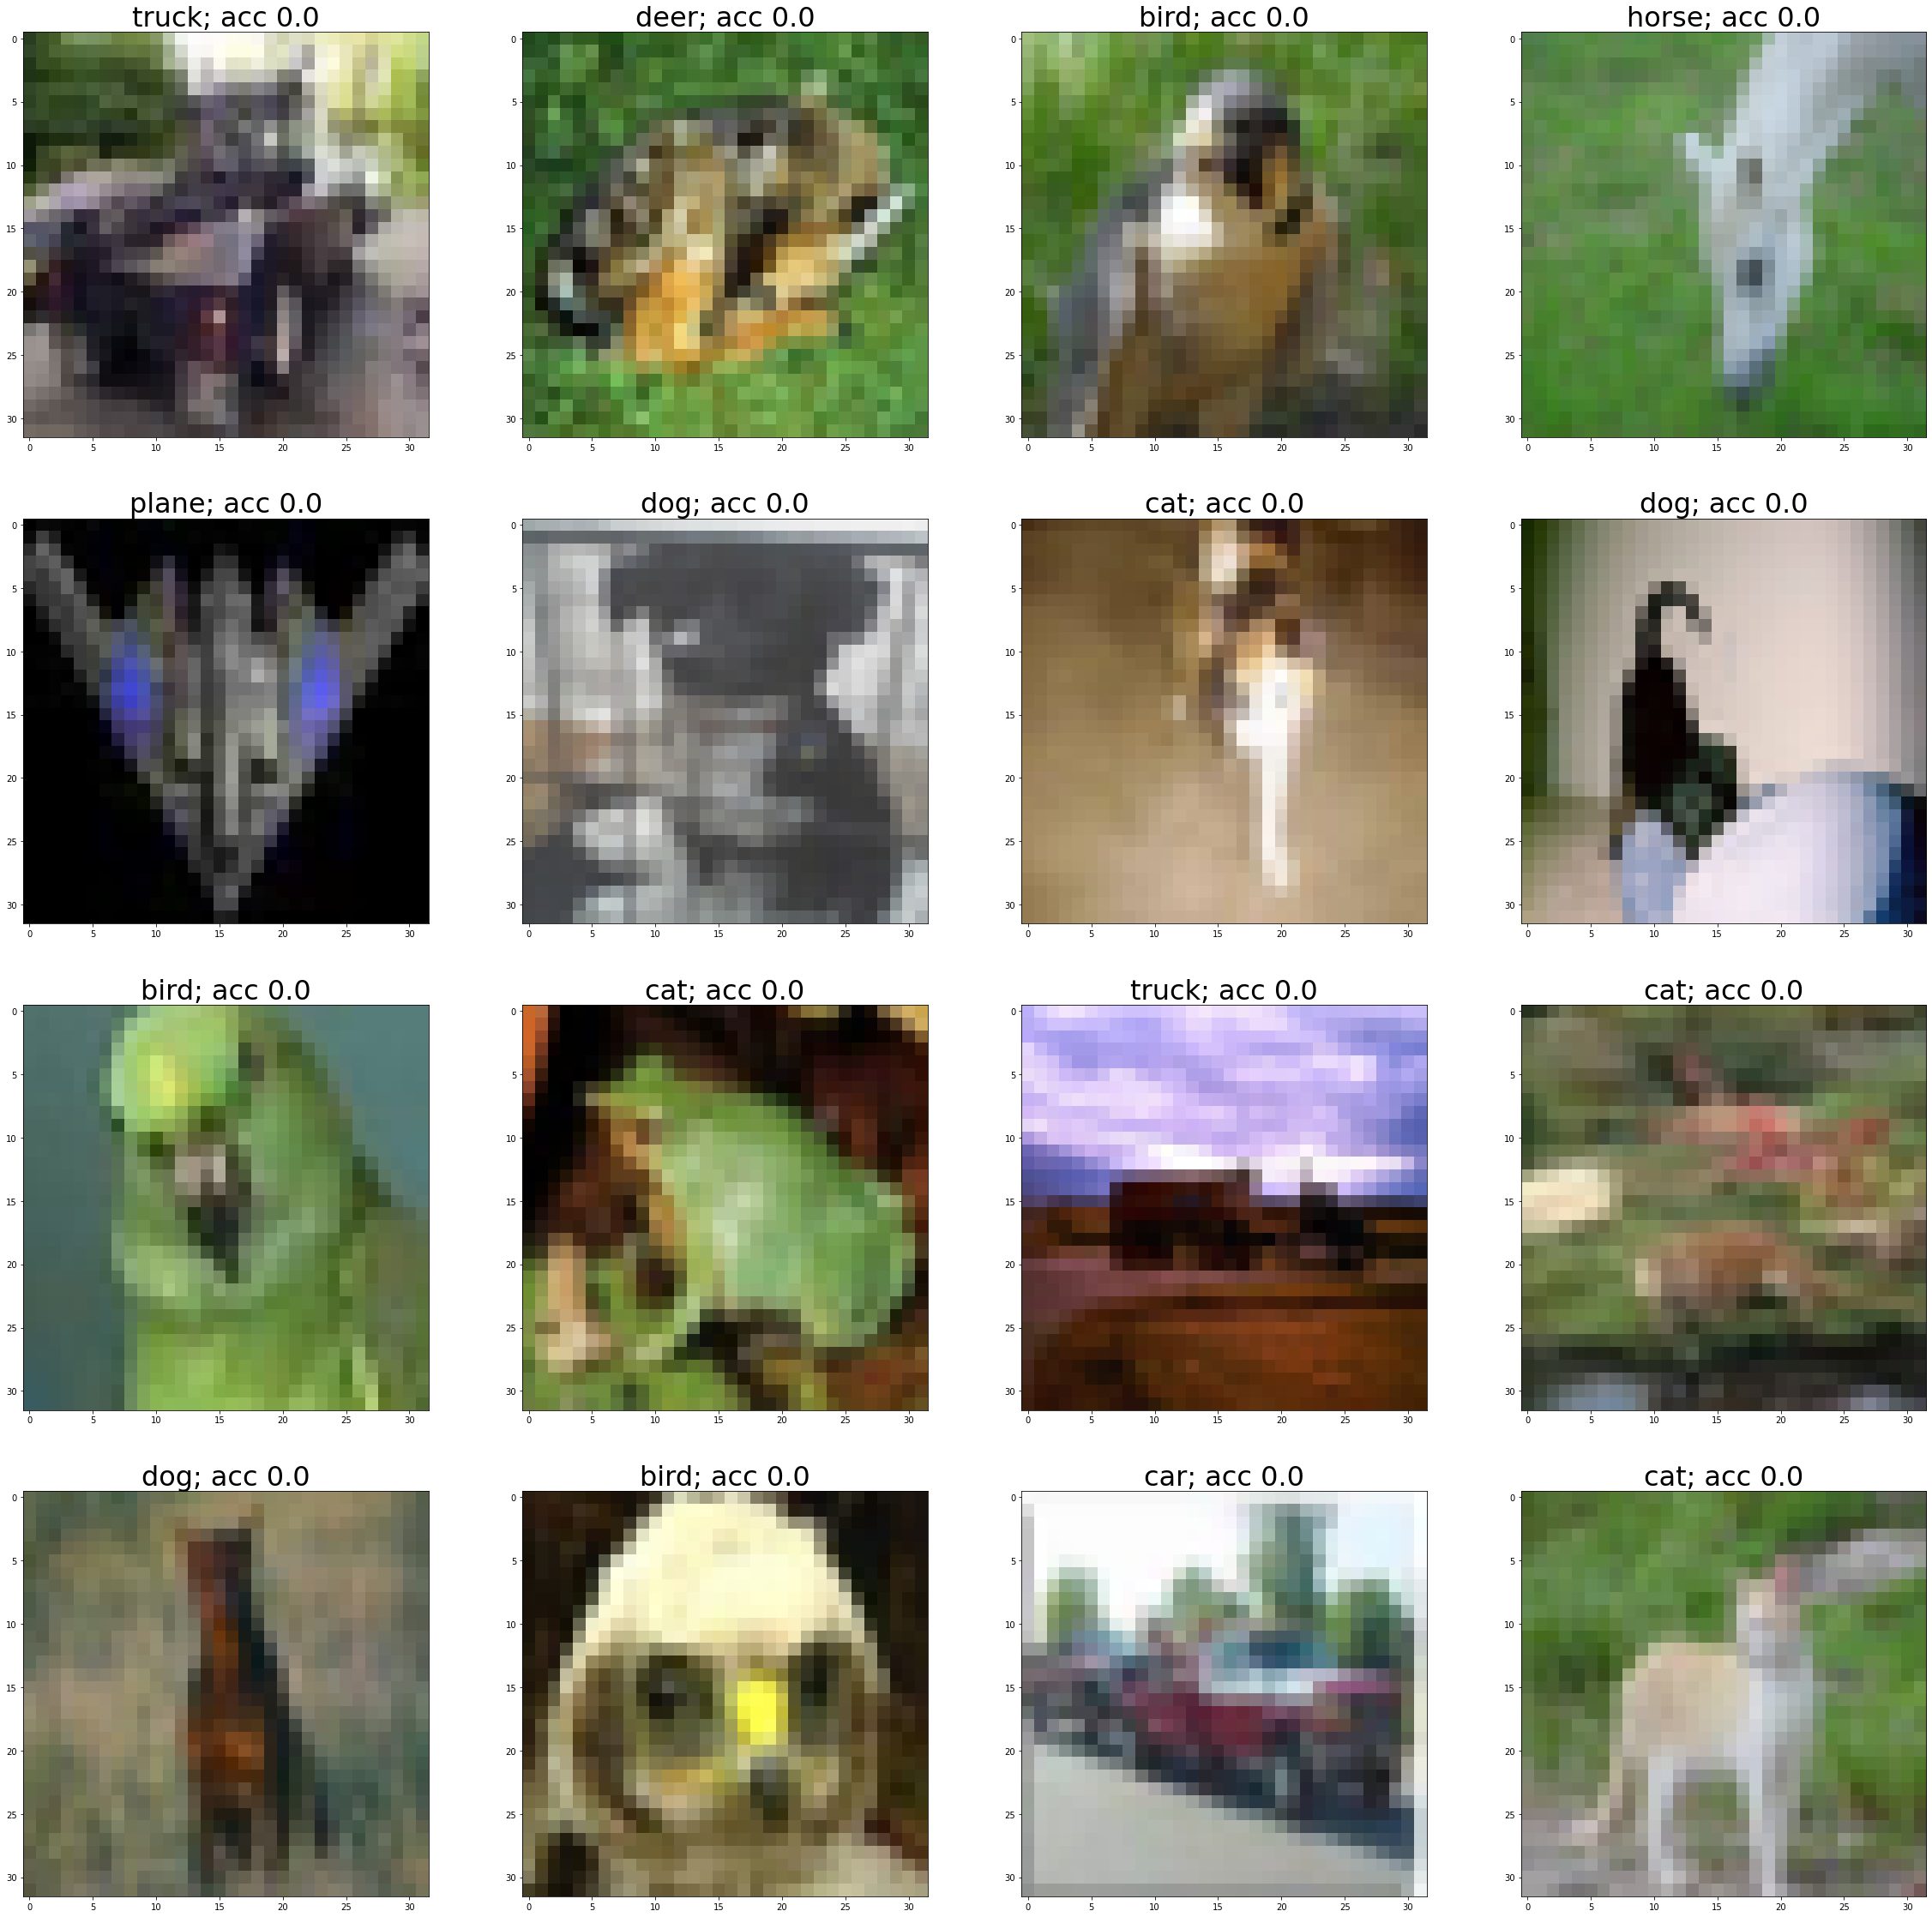

In [57]:
acc = out["acc_test"].mean(axis = 0)
data = testset
plt.figure(figsize=(width, height))
for i, ix in enumerate(np.argsort(acc)[:num]):        
    image, label = data[ix]
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}; acc {acc[ix].round(3)}", fontsize = 32)

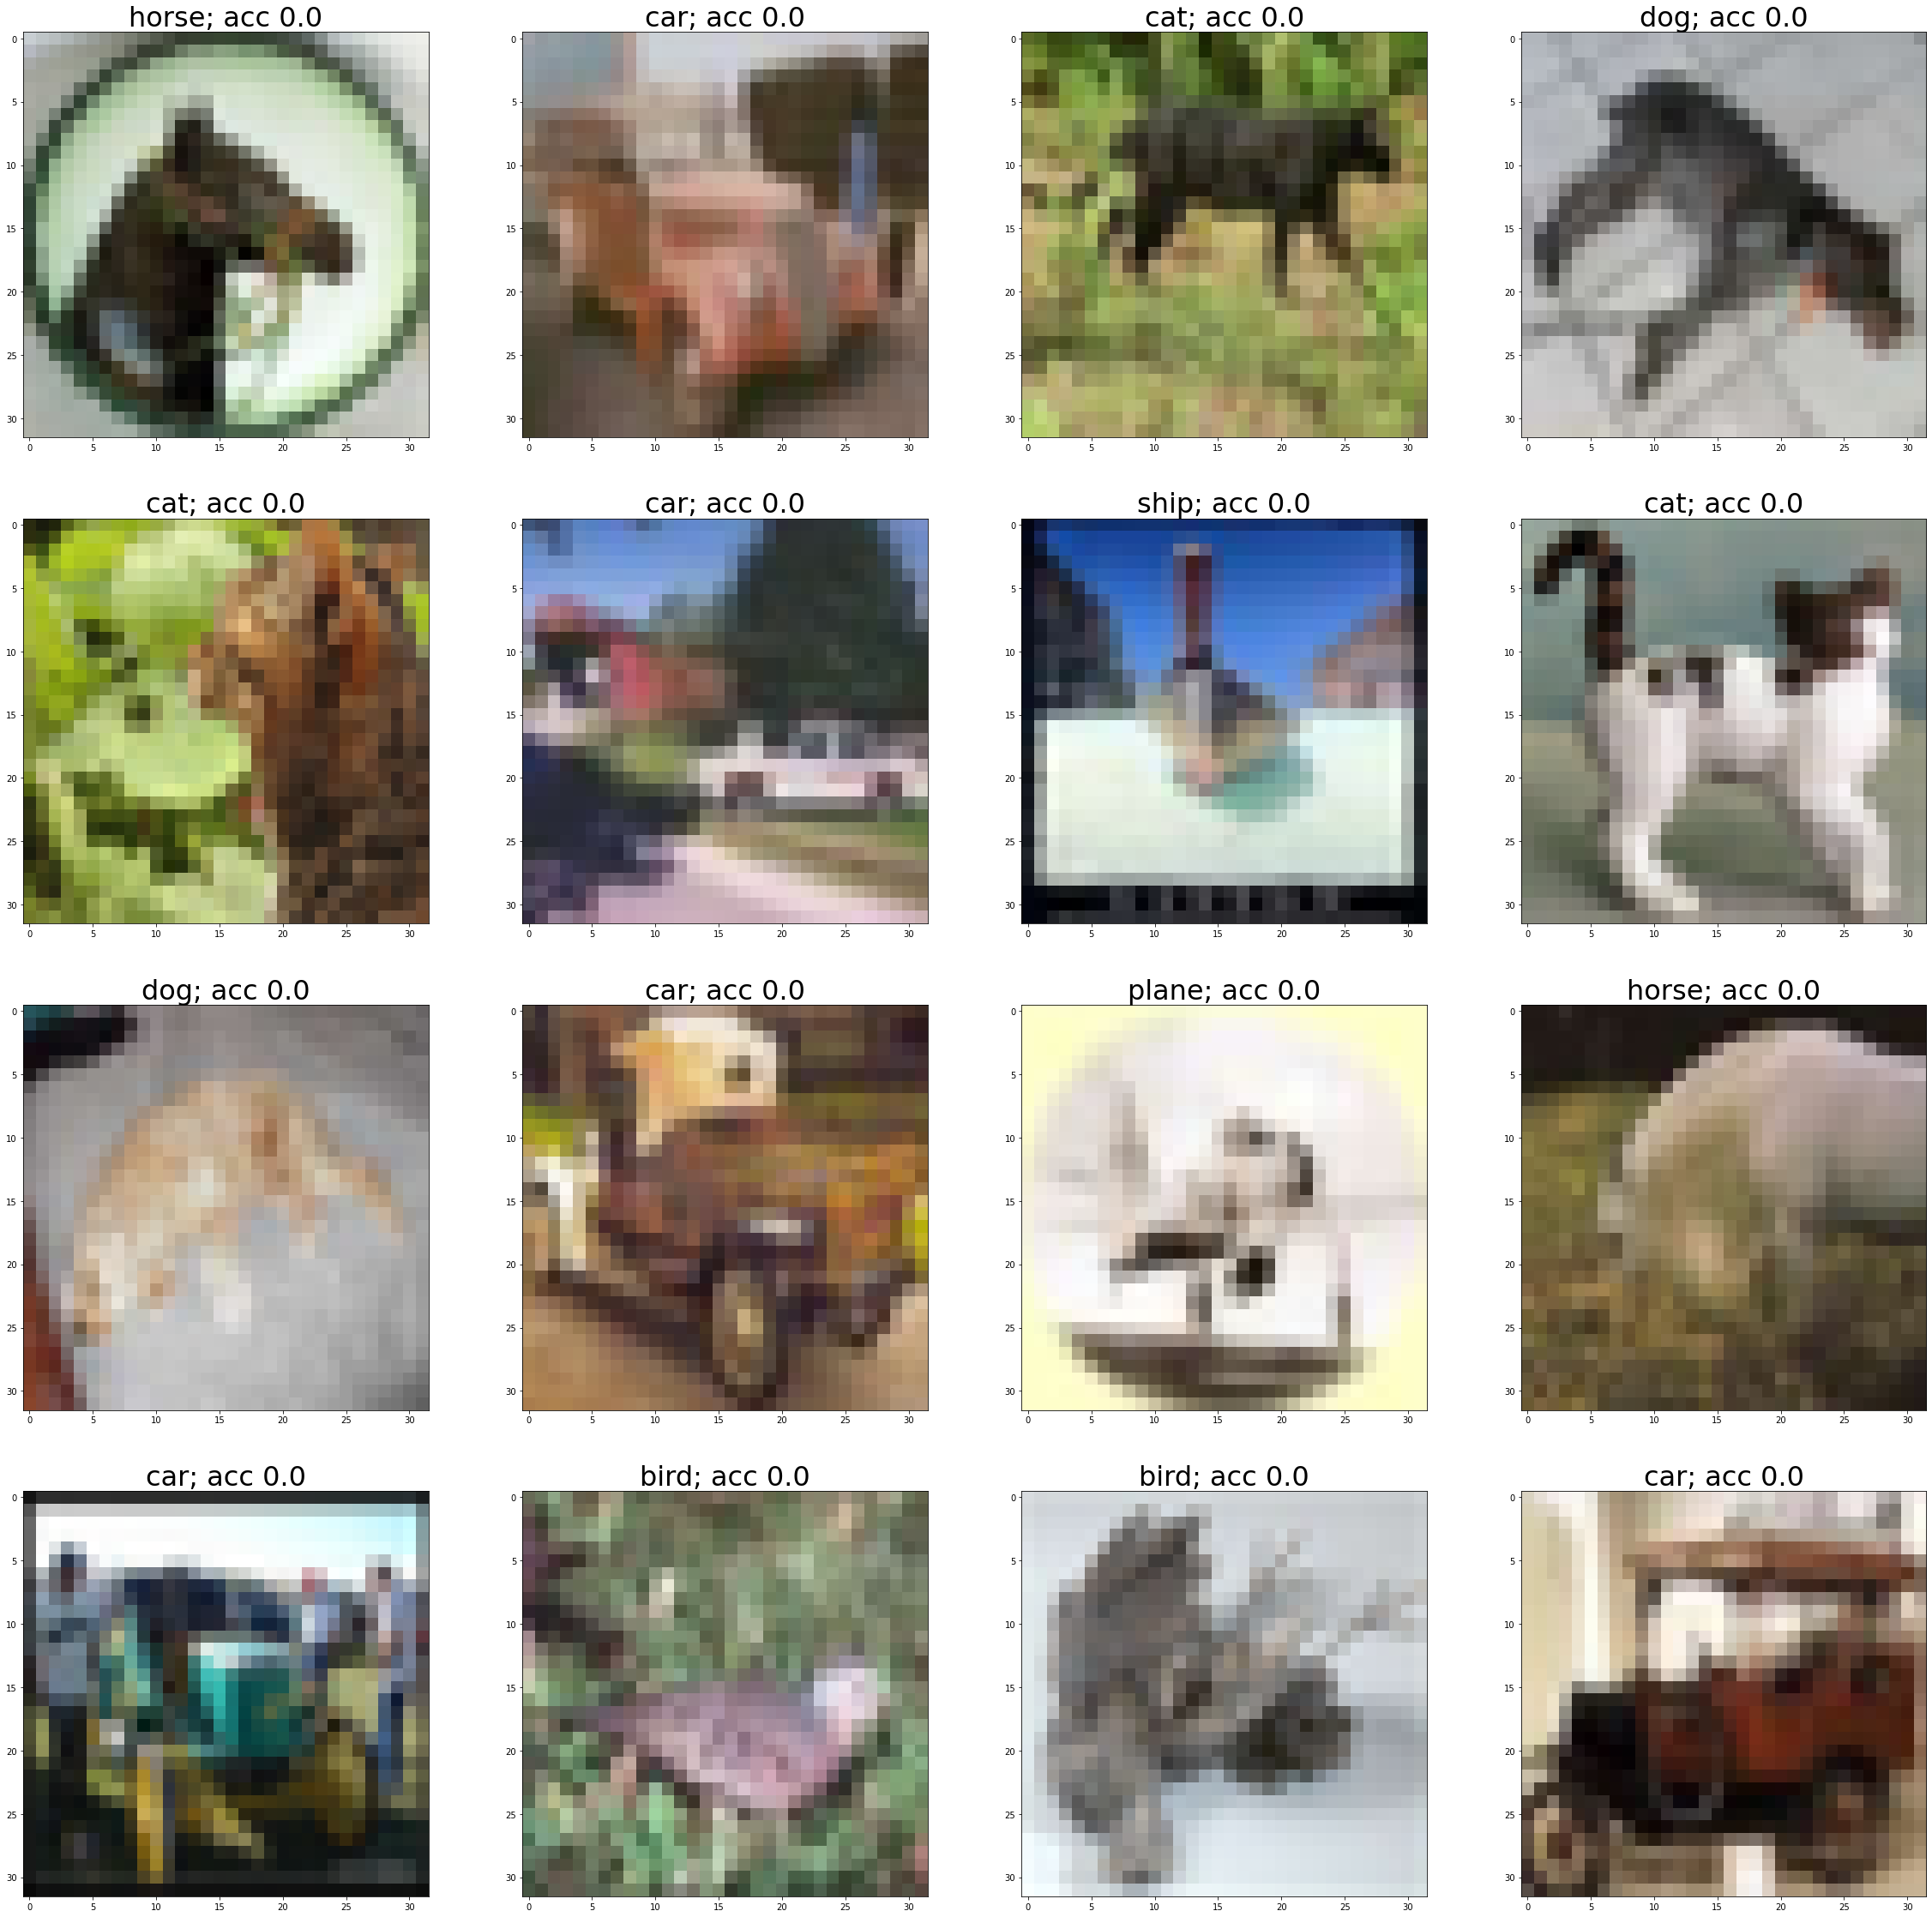

In [58]:
acc = out["acc_test_new"].mean(axis = 0)
data = testset_new
plt.figure(figsize=(width, height))
for i, ix in enumerate(np.argsort(acc)[:num]):        
    image, label = data[ix]
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}; acc {acc[ix].round(3)}", fontsize = 32)

Next, look at the memory score

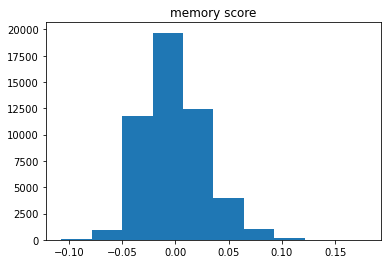

In [5]:
plt.hist(out['mem_score'])
plt.title("memory score")
plt.show()

biggest positive memory


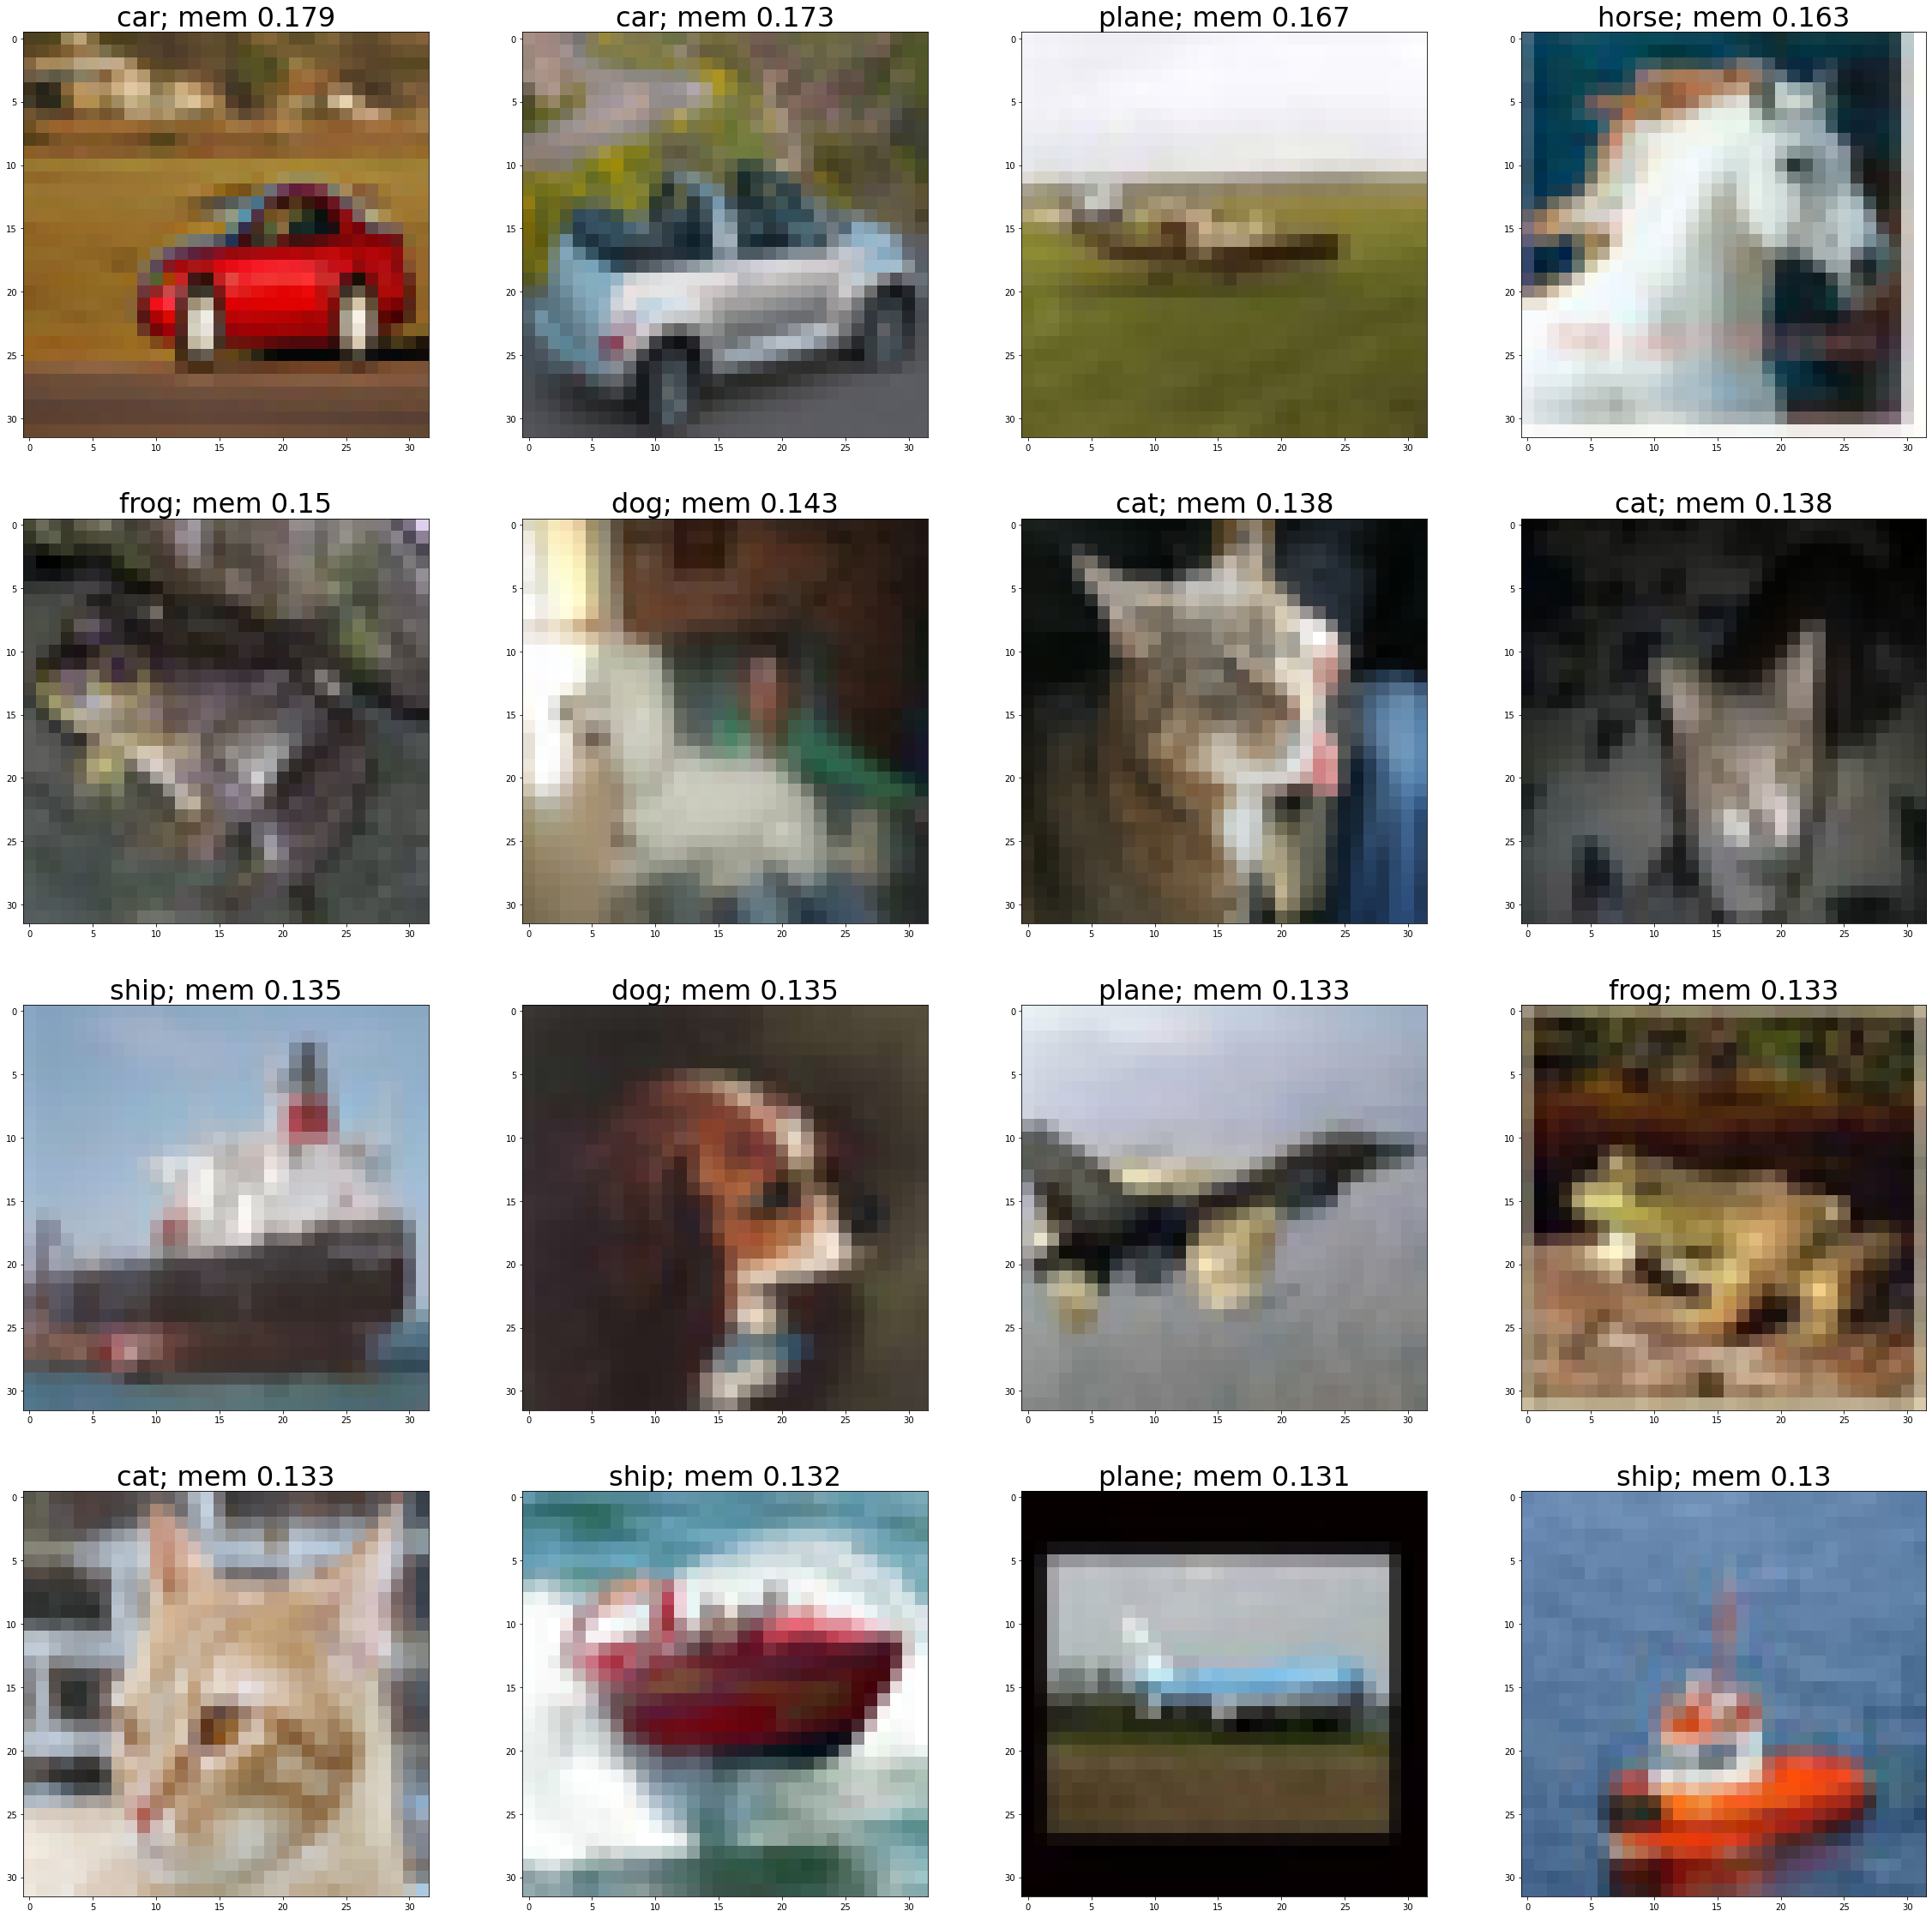

In [62]:
num = 16
columns=4
rows = int(num / columns)
width = 40
height = 40

print("biggest positive memory")
val = out['mem_score']
data = all_trainset
plt.figure(figsize=(width, height))
for i, ix in enumerate(np.argsort(-val)[:num]):        
    image, label = data[ix]
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}; mem {val[ix].round(3)}", fontsize = 32)

biggest negative memory


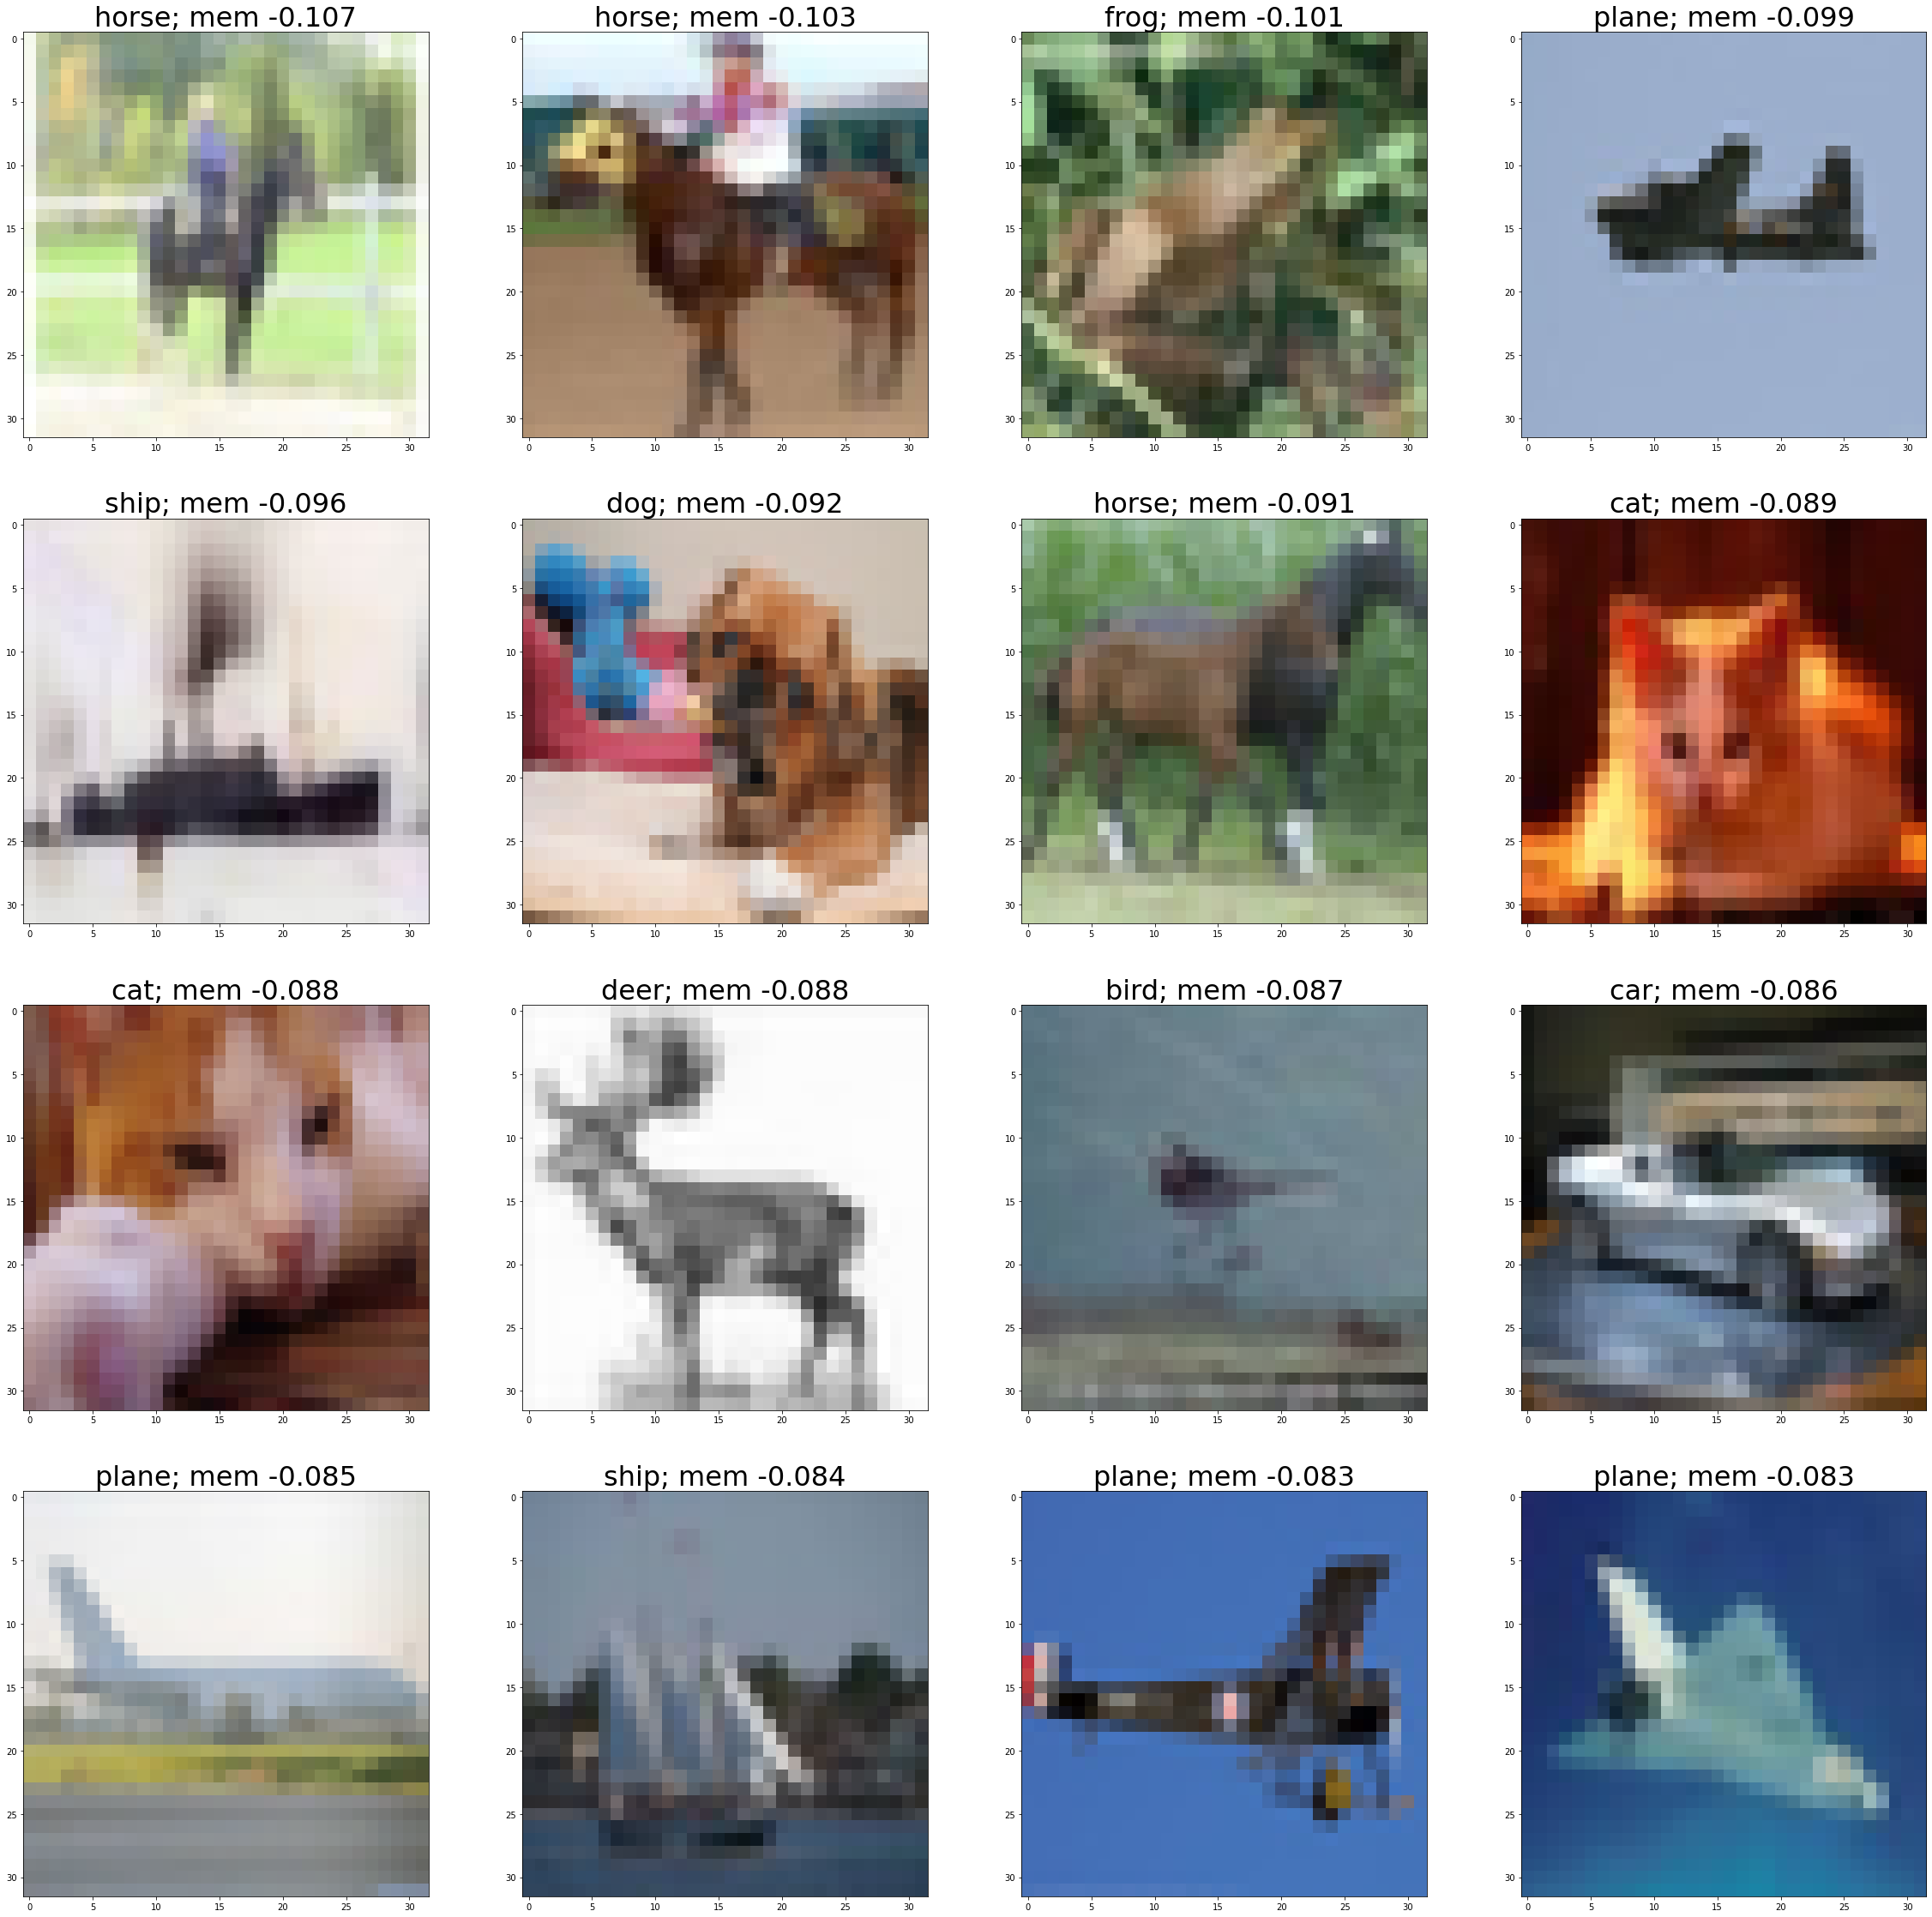

In [64]:
print("biggest negative memory")
val = out['mem_score']
data = all_trainset
plt.figure(figsize=(width, height))
for i, ix in enumerate(np.argsort(val)[:num]):        
    image, label = data[ix]
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}; mem {val[ix].round(3)}", fontsize = 32)

smallest abs memory


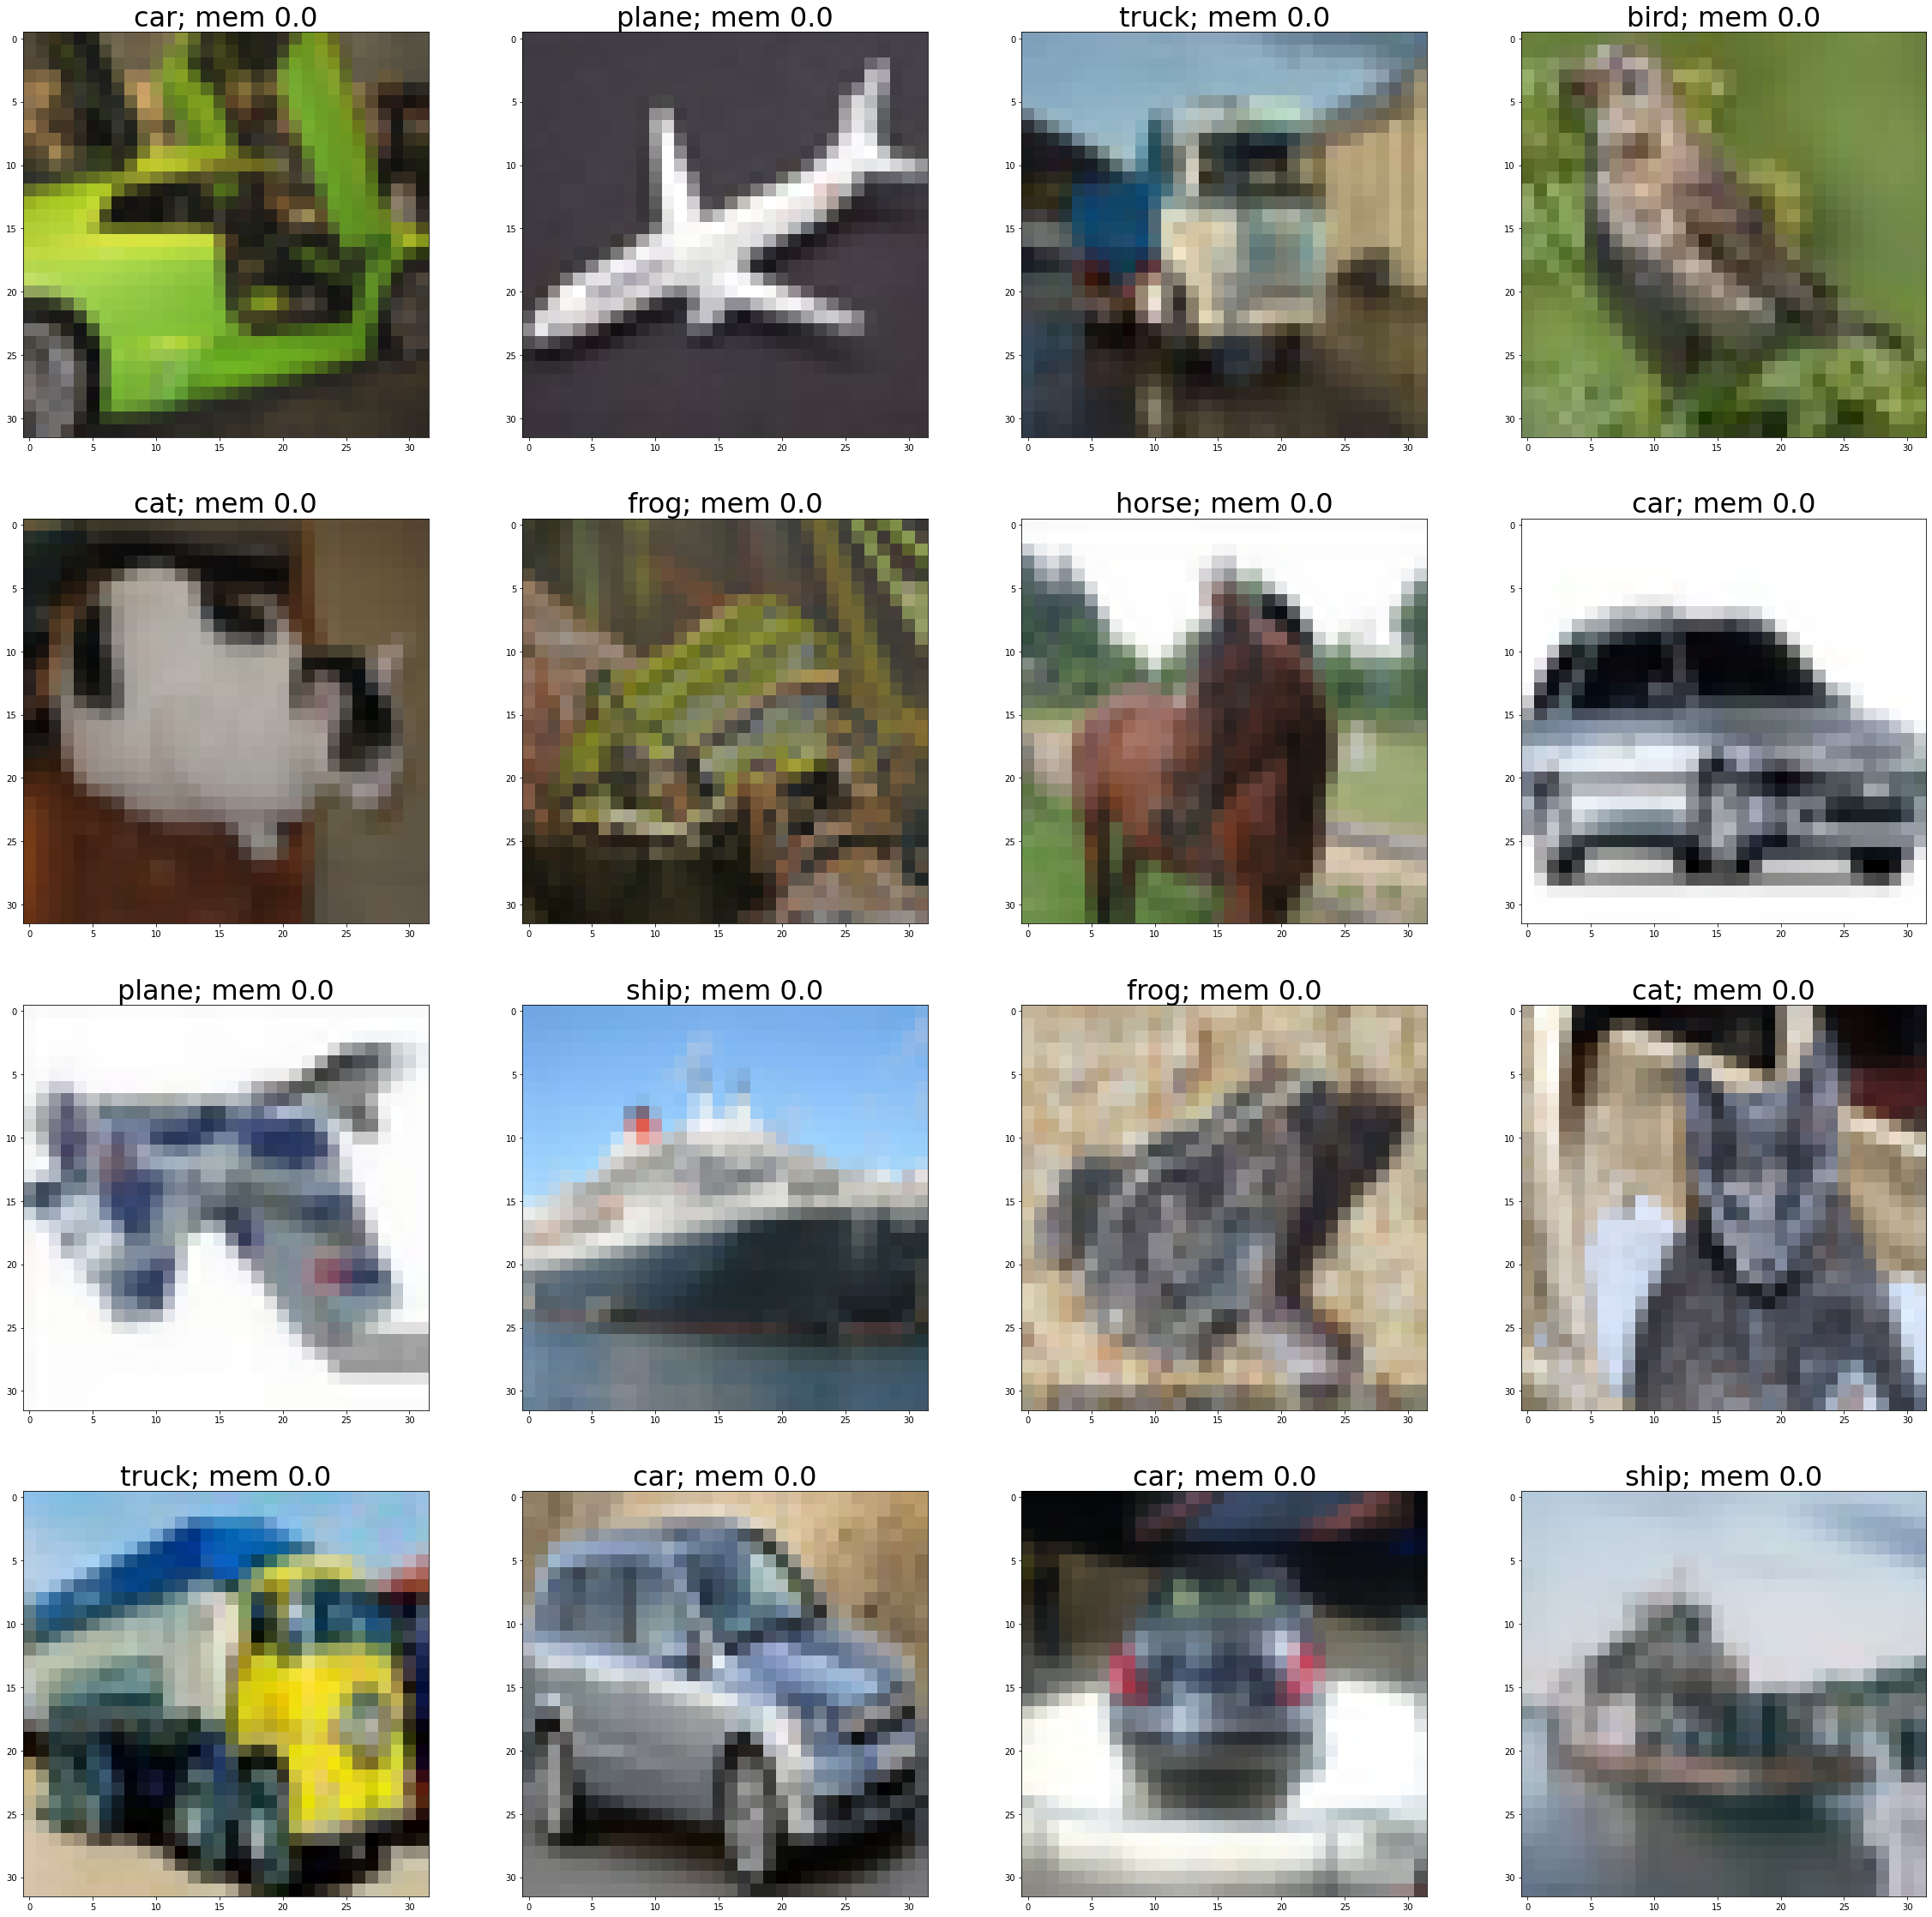

In [88]:
print("smallest abs memory")
val = out['mem_score']
data = all_trainset
plt.figure(figsize=(width, height))
for i, ix in enumerate(np.argsort(np.abs(val))[:num]):        
    image, label = data[ix]
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}; mem {val[ix].round(3)}", fontsize = 32)

We pick the top samples with the 1% memory score, and compute their influence on the test and new-test data

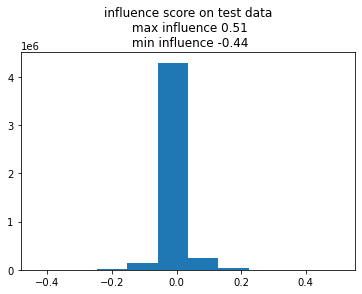

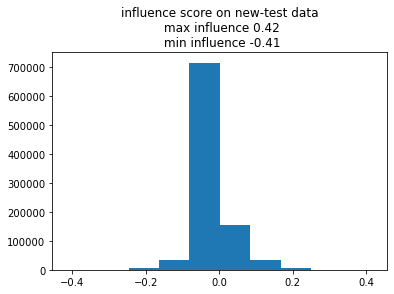

In [7]:
plt.hist(out['infl_score_test'].flatten())
plt.title(f"influence score on test data\n \
max influence {out['infl_score_test'].max().round(2)}\n \
min influence {out['infl_score_test'].min().round(2)}")
plt.show()

plt.hist(out['infl_score_testnew'].flatten())
plt.title(f"influence score on new-test data\n \
max influence {out['infl_score_testnew'].max().round(2)}\n \
min influence {out['infl_score_testnew'].min().round(2)}")
plt.show()

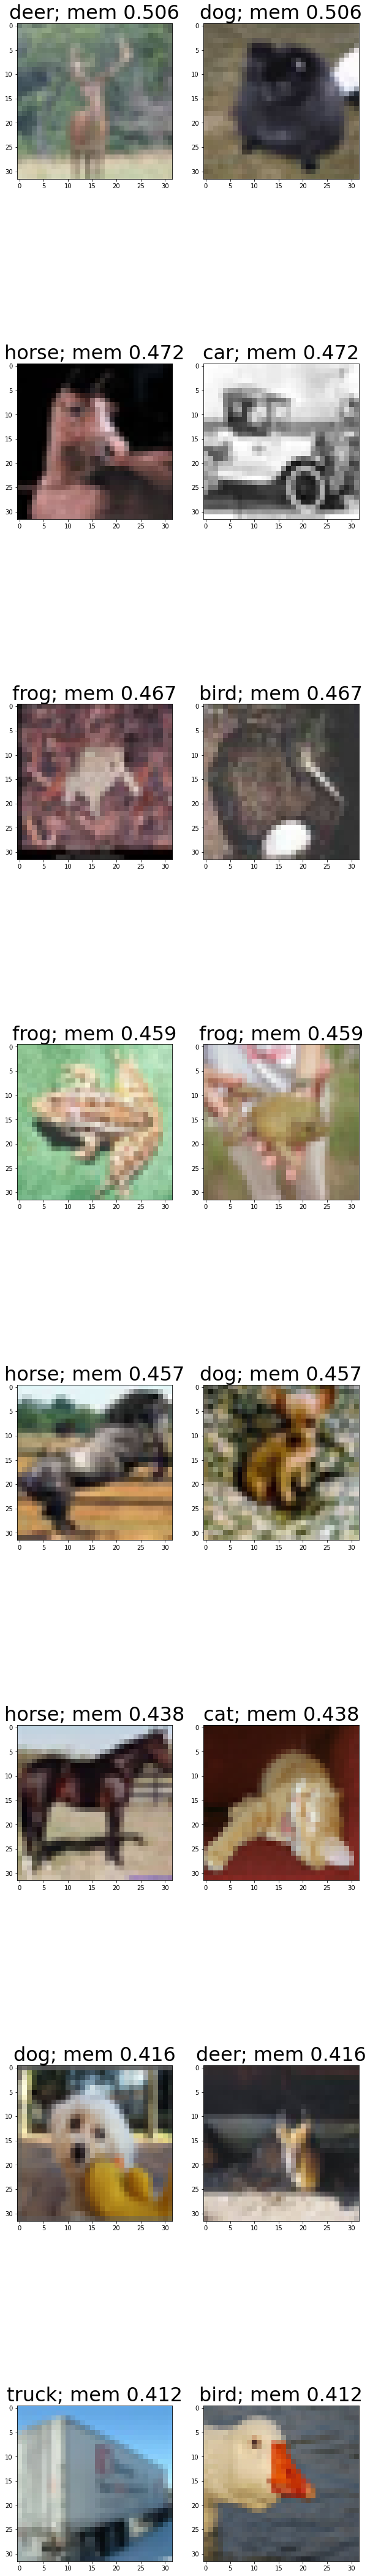

In [92]:
i = 0
# r,c = np.dstack(np.unravel_index(np.argsort(-val.ravel()), val.shape))[0][i, :]
# val[r, c]

num = 16
columns=2
rows = 8
width = 10
height = 80

val = out['infl_score_test']
data1 = all_trainset
data2 = testset

indices = np.dstack(np.unravel_index(np.argsort(-val.ravel()), val.shape))[0][:int(num/2), :]
plt.figure(figsize=(width, height))
for i, (r, c) in enumerate(indices):
    image, label = data1[r]
    plt.subplot(rows, columns, 2*i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}; infl {val[r, c].round(3)}", fontsize = 32)
    
    image, label = data2[c]
    plt.subplot(rows, columns, 2*i + 2)
    plt.imshow(image)
    plt.title(f"{classes[label]}", fontsize = 32)

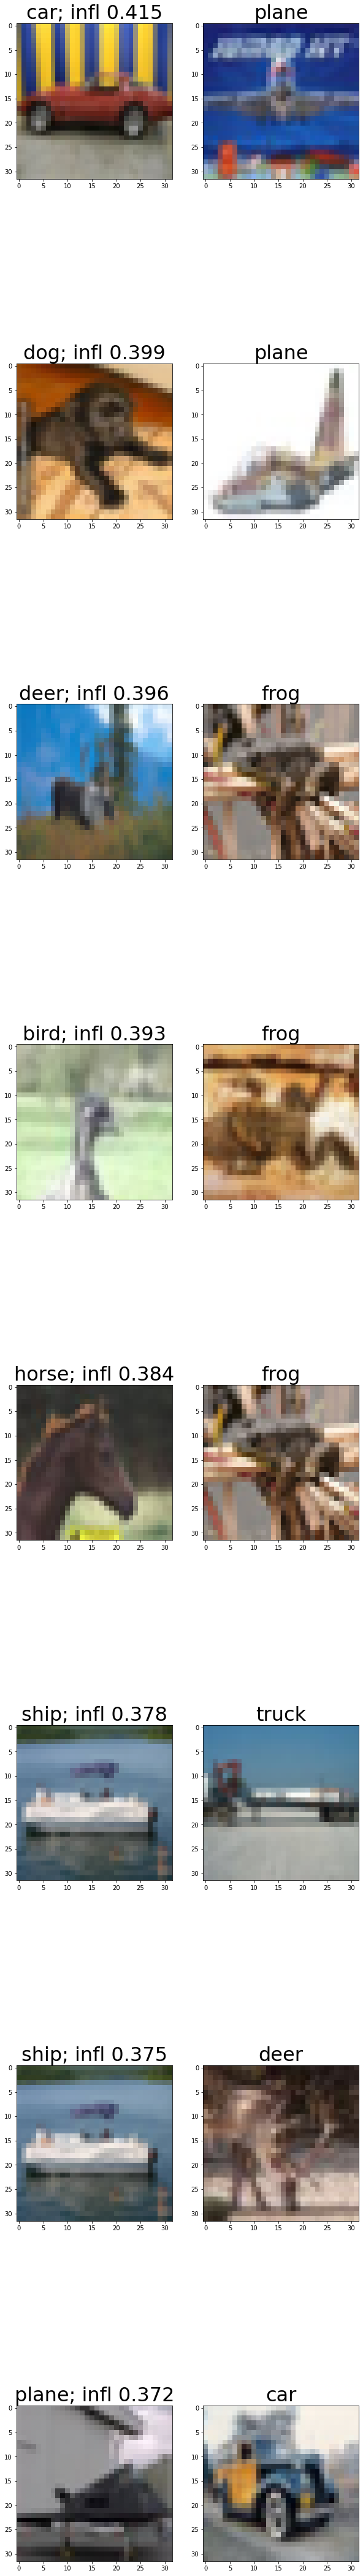

In [93]:
i = 0
# r,c = np.dstack(np.unravel_index(np.argsort(-val.ravel()), val.shape))[0][i, :]
# val[r, c]

num = 16
columns=2
rows = 8
width = 10
height = 80

val = out['infl_score_testnew']
data1 = all_trainset
data2 = testset_new

indices = np.dstack(np.unravel_index(np.argsort(-val.ravel()), val.shape))[0][:int(num/2), :]
plt.figure(figsize=(width, height))
for i, (r, c) in enumerate(indices):
    image, label = data1[r]
    plt.subplot(rows, columns, 2*i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}; infl {val[r, c].round(3)}", fontsize = 32)
    
    image, label = data2[c]
    plt.subplot(rows, columns, 2*i + 2)
    plt.imshow(image)
    plt.title(f"{classes[label]}", fontsize = 32)